In [38]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd


################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

def open_image(url):
    image_data = open_http_query(url)
    
    if not image_data:
            return None
            
    mmap_name = "/vsimem/"+uuid4().get_hex()
    gdal.FileFromMemBuffer(mmap_name, image_data.read())
    gdal_dataset = gdal.Open(mmap_name)
    image = gdal_dataset.GetRasterBand(1).ReadAsArray()
    gdal_dataset = None
    gdal.Unlink(mmap_name)
    
    return image

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/GAstart"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "processing_data_11082018" #output suffix for the files and ouptut folder
#ARGS 8
num_cores = 2 # number of cores
file_format = ".tif"

dem_baltimore_filename = "DEM_BaltArea_1m.tif"
landcover_baltimore_filename = "landCover_area1m.tif"
reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir = "output_data_"+out_suffix
    out_dir = os.path.join(in_dir,out_dir)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


   OBJECTID mde6digt        mde6name  mde8digt               mde8name  \
0        61   021309  PATAPSCO RIVER  02130905           Gwynns Falls   
1        63   021309  PATAPSCO RIVER  02130904            Jones Falls   
2        68   021309  PATAPSCO RIVER  02130901             Back River   
3        70   021309  PATAPSCO RIVER  02130906  Patapsco River L N Br   
4        73   021309  PATAPSCO RIVER  02130903       Baltimore Harbor   

                                             weblink       cbi  \
0  http://mddnr.chesapeakebay.net/wsprofiles/surf...  2.510101   
1  http://mddnr.chesapeakebay.net/wsprofiles/surf...  3.021277   
2  http://mddnr.chesapeakebay.net/wsprofiles/surf...  1.892857   
3  http://mddnr.chesapeakebay.net/wsprofiles/surf...  2.561661   
4  http://mddnr.chesapeakebay.net/wsprofiles/surf...  2.378571   

                                            geometry  
0  POLYGON ((-8552481.550799999 4790048.482500002...  
1  POLYGON ((-8526477.726900002 4779313.976200014...  

AttributeError: type object 'object' has no attribute '__getattr__'

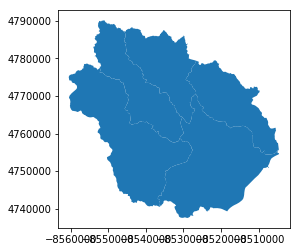

In [39]:
#######################################
### PART 1: Read in DATA #######

dem_baltimore_filename = os.path.join(in_dir,dem_baltimore_filename)
landcover_baltimore_filename = os.path.join(in_dir,landcover_baltimore_filename)
reg_outline_filename = os.path.join(in_dir,reg_outline_filename)

reg_gpd = gpd.read_file(reg_outline_filename)
reg_gpd.plot()
print(reg_gpd) 

dem_baltimore = rasterio.open(os.path.join(in_dir,dem_baltimore_filename))


#########################################
### PART 2: Crop to region of interest #######
#Open existing raster ds

dem_baltimore = gdal.Open(os.path.join(in_dir,dem_baltimore_filename))
reg_dem_gpd = reg_gpd.to_crs(dem_baltimore.crs)

extent_val = reg_dem_gpd.total_bounds #minx,MINY,MAXX,MAXY

#gdalwarp -te -122.4267 37.7492 -122.4029 37.769 sf_4269.tif sf_4269-clippedByCoords.tif
#find option using
#gdal.WarpOptions()
gdal.Warp("cropped_dem.tif",dem_baltimore,outputBounds=extent_val)
#for i in range(1,src_ds.RasterCount +1): #Save bands as individual files
#    out_ds = gdal.Translate(out_path + 'band' + str(i) + '.tiff', src_ds, format='GTiff', bandList=[i])
#    out_ds=None
dem_baltimore= None
#" -te <x_min> <y_min> <x_max> <y_max>",
#extent_gdal <- extent_val[c(1,3,2,4)]
    
#from osgeo import gdal

#bbox = (minX,maxY,maxX,minY) #Reorder bbox to use with gdal_translate

#Clip raster to shapefile bounding box
#clip = gdal.Translate('path/to/output', Raster, projWin=bbox)

#reg_sf_lc <- st_transform(reg_sf,projection(r_lc))

#reg_sp_lc <- as(reg_sf_lc,"Spatial")
#r_lc_crop <- crop(r_lc,reg_sp_lc)
#lc_crop_baltimore_filename <- paste0("r_lc_crop_",out_suffix,file_format)
#writeRaster(r_lc_crop,filename = file.path(out_dir,lc_crop_baltimore_filename))

lc_baltimore = gdal.Open(os.path.join(in_dir,lc_baltimore_filename))

#gdalwarp -te -122.4267 37.7492 -122.4029 37.769 sf_4269.tif sf_4269-clippedByCoords.tif
#find option using
#gdal.WarpOptions()
reg_lc_gpd = reg_gpd.to_crs(lc_baltimore.crs)

extent_val = reg_lc_gpd.total_bounds #minx,MINY,MAXX,MAXY

gdal.Warp("cropped_lc.tif",lc_baltimore,outputBounds=extent_val)
#for i in range(1,src_ds.RasterCount +1): #Save bands as individual files
#    out_ds = gdal.Translate(out_path + 'band' + str(i) + '.tiff', src_ds, format='GTiff', bandList=[i])
#    out_ds=None
dem_baltimore= None

#########################
### PART 3: reproject raster to Maryland State plane #######

#local md projection:
#crs_reg = "+proj=lcc +lat_1=39.45 +lat_2=38.3 +lat_0=37.66666666666666 +lon_0=-77 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs" 
